In [28]:
import cv2
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.io import imread
from skimage.transform import rotate, resize

#Code from https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

MAX_FEATURES = 2000
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = im1
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    return im1Reg, im2, h

In [29]:
# Open the image files.
imReference = cv2.imread("Filters-Round-1/RGB_0.5.tif") # Image to be aligned.
im = cv2.imread("Fruit-Bowl/Rhine_2_RGB_0.5.tif") # Reference image.
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, imFilt, h = alignImages(im, imReference)



Aligning images ...


In [107]:
#Process imReg and imFilt to make imColor
print("Running Levi's Superpositioning Code")
imFilt_Red = abs(imFilt[:,:,0])
imFilt_Green = abs(imFilt[:,:,1])
imFilt_Blue = abs(imFilt[:,:,2])

imColor_Red = imReg * imFilt_Red
imColor_Green = cv2.multiply(imReg, imFilt_Green)
imColor_Blue = imReg * imFilt_Blue

Running Levi's Superpositioning Code


error: OpenCV(4.5.5) /io/opencv/modules/core/src/arithm.cpp:672: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'arithm_op'


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
Saving aligned image :  aligned.jpg
Estimated homography : 
 [[ 9.99160201e-01  2.17807879e-02 -1.51452209e+02]
 [-2.08879106e-02  1.00150772e+00 -1.59567046e+01]
 [-1.53673809e-07  2.24598572e-07  1.00000000e+00]]


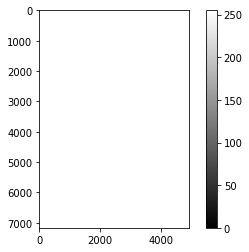

In [106]:
imColor = imRegUnNoise * imFilt
plt.imshow(imColor_Green, cmap="gray")
plt.colorbar()
print(imColor_Green)
# Write aligned image to disk.
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename);
cv2.imwrite(outFilename, imColor_Green)

# Print estimated homography
print("Estimated homography : \n",  h)